Helpful links:

* [Link1](https://github.com/WillKoehrsen/Data-Analysis/blob/master/prediction-intervals/prediction_intervals.ipynb)
* [Link2](https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed)

# Imports

In [1]:
import os
import sys
import itertools
from typing import List

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
sys.path.append("../../")
sys.path.append("../../source_code")

from source_code import (utils, analysis, feature_engineering, modelling)

print("Last Modified: ", utils.current_timestamp())

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Last Modified:  08-06-2021_09-06-41


In [2]:
data_path = '~/../../media/sf_data/'
data_path = '/Users/jeremy/data/'

In [3]:
train = pd.read_csv(data_path + 'air_pollution_predictor/train.csv')
test = pd.read_csv(data_path + 'air_pollution_predictor/test.csv')

In [4]:
TARGET_COLUMNS =  [col for col in train.columns if 'target' in col]
FEATURE_COLUMNS = [col for col in train.columns if col not in TARGET_COLUMNS]
ORIGINAL_NUM_FEATURE_COLUMNS = train[FEATURE_COLUMNS].select_dtypes(include=np.number).columns

# Feature Engineering

In [5]:
def feature_hourly_lag(df: pd.DataFrame, lag_features: List[str], lags: List[int]) -> pd.DataFrame:
    for feature, lag in itertools.product(lag_features, lags):
        df[feature + '_' + str(lag) + '_lag'] = df[feature] - df[feature].shift(periods=lag, fill_value=0)
    return df

def data_preprocessing(df) -> pd.DataFrame:
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['year'] = df['date_time'].dt.year
    df['month'] = df['date_time'].dt.month
    df['week'] = df['date_time'].dt.week
    df['day'] = df['date_time'].dt.day
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df['hour'] = df['date_time'].dt.hour
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['working_hours'] = (df['hour'].isin(np.arange(7, 20))).astype(int)
    df['night_hours'] = (~(df['hour'].isin(np.arange(6, 22)))).astype(int)
    df['season'] = feature_engineering.get_season_from_date_time_feature(
        df['date_time'])
    # df.drop(['date_time'],axis=1, inplace=True)

    # SMC - Site mean concentration, calculation: (absolute_humid * 100)/(relative humidity)
    df['smc'] = (100 * df['absolute_humidity']) / df['relative_humidity']

    # Introduce Lags
    df = feature_hourly_lag(df, ['sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','smc', 'absolute_humidity', 'deg_C'], [1,2,3,6,12,24])

    df.replace(to_replace=np.inf, value=0, inplace=True)
    return df

In [6]:
train = data_preprocessing(train)
test = data_preprocessing(test)

/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [7]:
NUM_FEATURE_COLUMNS = train[FEATURE_COLUMNS].select_dtypes(include=np.number).columns

In [8]:
train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,year,month,week,day,day_of_week,hour,is_weekend,working_hours,night_hours,season,smc,sensor_1_1_lag,sensor_1_2_lag,sensor_1_3_lag,sensor_1_6_lag,sensor_1_12_lag,sensor_1_24_lag,sensor_2_1_lag,sensor_2_2_lag,sensor_2_3_lag,sensor_2_6_lag,sensor_2_12_lag,sensor_2_24_lag,sensor_3_1_lag,sensor_3_2_lag,sensor_3_3_lag,sensor_3_6_lag,sensor_3_12_lag,sensor_3_24_lag,sensor_4_1_lag,sensor_4_2_lag,sensor_4_3_lag,sensor_4_6_lag,sensor_4_12_lag,sensor_4_24_lag,sensor_5_1_lag,sensor_5_2_lag,sensor_5_3_lag,sensor_5_6_lag,sensor_5_12_lag,sensor_5_24_lag,smc_1_lag,smc_2_lag,smc_3_lag,smc_6_lag,smc_12_lag,smc_24_lag,absolute_humidity_1_lag,absolute_humidity_2_lag,absolute_humidity_3_lag,absolute_humidity_6_lag,absolute_humidity_12_lag,absolute_humidity_24_lag,deg_C_1_lag,deg_C_2_lag,deg_C_3_lag,deg_C_6_lag,deg_C_12_lag,deg_C_24_lag
0,2010-03-10 18:00:00,13.100,46.000,0.758,1387.200,1087.800,1056.000,1742.800,1293.400,2.500,12.000,167.700,2010,3,10,10,2,18,0,1,0,2,1.647,1387.200,1387.200,1387.200,1387.200,1387.200,1387.200,1087.800,1087.800,1087.800,1087.800,1087.800,1087.800,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1742.800,1742.800,1742.800,1742.800,1742.800,1742.800,1293.400,1293.400,1293.400,1293.400,1293.400,1293.400,1.647,1.647,1.647,1.647,1.647,1.647,0.758,0.758,0.758,0.758,0.758,0.758,13.100,13.100,13.100,13.100,13.100,13.100
1,2010-03-10 19:00:00,13.200,45.300,0.726,1279.100,888.200,1197.500,1449.900,1010.900,2.100,9.900,98.900,2010,3,10,10,2,19,0,1,0,2,1.602,-108.100,1279.100,1279.100,1279.100,1279.100,1279.100,-199.600,888.200,888.200,888.200,888.200,888.200,141.500,1197.500,1197.500,1197.500,1197.500,1197.500,-292.900,1449.900,1449.900,1449.900,1449.900,1449.900,-282.500,1010.900,1010.900,1010.900,1010.900,1010.900,-0.046,1.602,1.602,1.602,1.602,1.602,-0.032,0.726,0.726,0.726,0.726,0.726,0.100,13.200,13.200,13.200,13.200,13.200
2,2010-03-10 20:00:00,12.600,56.200,0.750,1331.900,929.600,1060.200,1586.100,1117.000,2.200,9.200,127.100,2010,3,10,10,2,20,0,0,0,2,1.335,52.800,-55.300,1331.900,1331.900,1331.900,1331.900,41.400,-158.200,929.600,929.600,929.600,929.600,-137.300,4.200,1060.200,1060.200,1060.200,1060.200,136.200,-156.700,1586.100,1586.100,1586.100,1586.100,106.100,-176.400,1117.000,1117.000,1117.000,1117.000,-0.267,-0.313,1.335,1.335,1.335,1.335,0.025,-0.008,0.750,0.750,0.750,0.750,-0.600,-0.500,12.600,12.600,12.600,12.600
3,2010-03-10 21:00:00,11.000,62.400,0.787,1321.000,929.000,1102.900,1536.500,1263.200,2.200,9.700,177.200,2010,3,10,10,2,21,0,0,0,2,1.261,-10.900,41.900,-66.200,1321.000,1321.000,1321.000,-0.600,40.800,-158.800,929.000,929.000,929.000,42.700,-94.600,46.900,1102.900,1102.900,1102.900,-49.600,86.600,-206.300,1536.500,1536.500,1536.500,146.200,252.300,-30.200,1263.200,1263.200,1263.200,-0.074,-0.341,-0.387,1.261,1.261,1.261,0.036,0.061,0.029,0.787,0.787,0.787,-1.600,-2.200,-2.100,11.000,11.000,11.000
4,2010-03-10 22:00:00,11.900,59.000,0.789,1272.000,852.700,1180.900,1415.500,1132.200,1.500,6.400,121.800,2010,3,10,10,2,22,0,0,1,2,1.337,-49.000,-59.900,-7.100,1272.000,1272.000,1272.000,-76.300,-76.900,-35.500,852.700,852.700,852.700,78.000,120.700,-16.600,1180.900,1180.900,1180.900,-121.000,-170.600,-34.400,1415.500,1415.500,1415.500,-131.000,15.200,121.300,1132.200,1132.200,1132.200,0.076,0.002,-0.265,1.337,1.337,1.337,0.002,0.039,0.063,0.789,0.789,0.789,0.900,-0.700,-1.300,11.900,11.900,11.900


In [9]:
train_df = train.copy()
test_df = test.copy()

### Insight:

* skewed target features ... try log transformation

In [10]:
for feature in TARGET_COLUMNS:
    train_df[feature] = feature_engineering.log_scaling(train_df[feature])

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9

# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA)

In [12]:
test_size = 0.33
test_idx = int(1-len(train)*test_size)

In [13]:
train_df_clean = train_df.drop(['date_time'], axis=1)
test_df_clean = test_df.drop(['date_time'], axis=1)

In [29]:
tr = train_df_clean.iloc[:test_idx]
te = train_df_clean.iloc[test_idx:]


X_train = tr.drop(TARGET_COLUMNS,axis=1)
y_train = tr[TARGET_COLUMNS[0]]

X_test = te.drop(TARGET_COLUMNS,axis=1)
y_test = te[TARGET_COLUMNS[0]]

# Scale Numerical Data

In [30]:
num_features = X_train.select_dtypes(include=np.number).columns

In [31]:
scaler = MinMaxScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])
X_submission[num_features] = scaler.transform(test_df_clean[num_features])

In [32]:
# Fit models
lower_model.fit(X_train, y_train)
mid_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

GradientBoostingRegressor(loss='quantile')

In [33]:
# Record actual values on test set
predictions = pd.DataFrame(y_test)
predictions.columns = ['actual']
# Predict
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

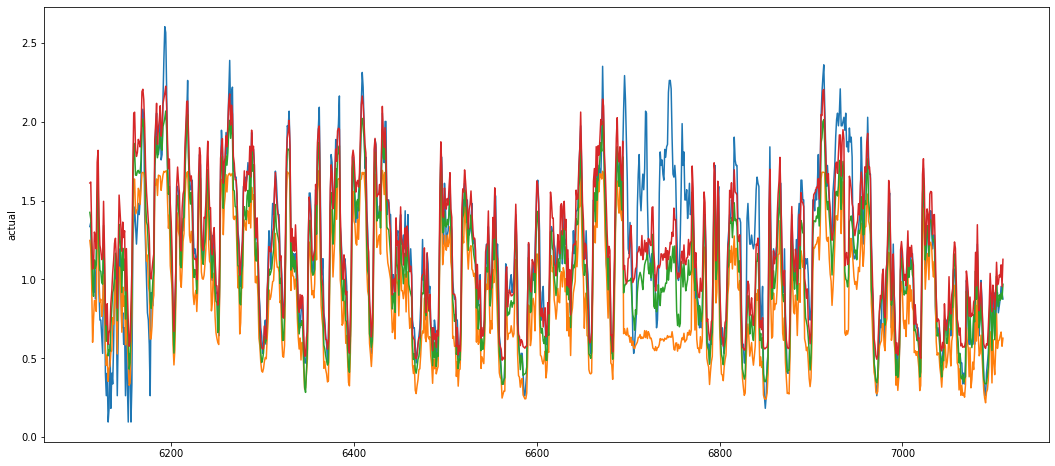

In [34]:
predictions_part = predictions[-1000:].copy()
fig = plt.figure(figsize=(18,8))
sns.lineplot(data=predictions_part['actual'])
sns.lineplot(data=predictions_part['lower'])
sns.lineplot(data=predictions_part['mid'])
sns.lineplot(data=predictions_part['upper'])
plt.show()

In [35]:
def calculate_interval_error(predictions: pd.DataFrame):
    predictions['absolute_error_lower'] = (predictions['actual'] - predictions['lower']).abs()
    predictions['absolute_error_upper'] = (predictions['actual'] - predictions['upper']).abs()

    predictions['absolute_error_interval'] = (predictions['absolute_error_lower'] + predictions['absolute_error_upper']) / 2
    predictions['absolute_error_mid'] = (predictions['mid'] - predictions['actual']).abs()

    predictions['in_bounds'] = predictions['actual'].between(left=predictions['lower'], right=predictions['upper'])

    return predictions[['absolute_error_lower', 'absolute_error_upper', 'absolute_error_interval', 'absolute_error_mid', 'in_bounds']]

In [36]:
metrics = calculate_interval_error(predictions)
metrics.describe()

,absolute_error_lower,absolute_error_upper,absolute_error_interval,absolute_error_mid
count,2345.000,2345.000,2345.000,2345.000
mean,0.231,0.133,0.182,0.124
std,0.204,0.131,0.140,0.146
min,0.000,0.000,0.050,0.000
25%,0.104,0.050,0.114,0.036
50%,0.188,0.104,0.144,0.086
75%,0.295,0.168,0.190,0.153
max,1.627,1.204,1.405,1.336


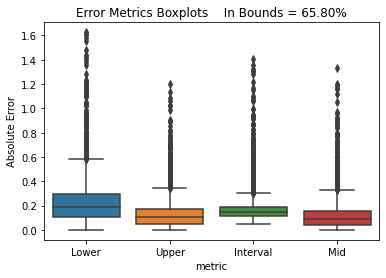

In [37]:
def visualise_metrics(metrics: pd.DataFrame):
    percent_in_bounds = metrics['in_bounds'].mean() * 100
    metrics_to_plot = metrics[[c for c in metrics if 'absolute_error' in c]]

    # Rename the columns
    metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]
    sns.boxplot(data = metrics_to_plot.melt(var_name="metric", value_name='Absolute Error'),
                x = 'metric',
                y='Absolute Error')
    plt.title(f"Error Metrics Boxplots    In Bounds = {percent_in_bounds:.2f}%")

visualise_metrics(metrics)

create a class which runs all the models together

In [38]:
from sklearn.base import BaseEstimator

class GradientBoostingPredictionIntervals(BaseEstimator):
    """
    Model that produces prediction intervals using sklearn's GradientBoostingRegressor
    """

    def __init__(self, lower_alpha = 0.1, upper_alpha = 0.9, **kwargs):
        """

        :param lower_alpha: lower quantile for prediction, default=0.1
        :param upper_alpha: upper quantile for prediction, default=0.9
        :param **kwargs: additional keyword arguments for creating a GradientBoostingRegressor model
        """
        self.lower_alpha = lower_alpha
        self.upper_alpha = upper_alpha

        self.lower_model = GradientBoostingRegressor(
            loss="quantile", alpha=self.lower_alpha, **kwargs
        )
        self.mid_model = GradientBoostingRegressor(loss="ls", **kwargs)
        self.upper_model = GradientBoostingRegressor(
            loss="quantile", alpha=self.upper_alpha, **kwargs
        )
        self.predictions = None

    def fit(self, X, y):
        """
        Fit all three models

        :param X: train features
        :param y: train targets
        """
        self.lower_model.fit(X, y)
        self.mid_model.fit(X, y)
        self.upper_model.fit(X, y)

    def predict(self, X, y):
        """

        :param X: test features
        :param y: test targets
        :return predictions: dataframe of predictions
        """
        predictions = pd.DataFrame(y)
        predictions.columns = ['actual']
        predictions["lower"] = self.lower_model.predict(X)
        predictions["mid"] = self.mid_model.predict(X)
        predictions["upper"] = self.upper_model.predict(X)
        self.predictions = predictions

        return predictions

    def plot_intervals(self):
        """
        Plot the prediction intervals

        :param mid: boolean for whether to show the mid prediction
        :param start: optional parameter for subsetting start of predictions
        :param stop: optional parameter for subsetting end of predictions

        :return fig: plotly figure
        """

        if self.predictions is None:
            raise ValueError("This model has not yet made predictions.")
            return

        fig = plt.figure(figsize=(18,8))
        sns.lineplot(data=predictions['actual'])
        sns.lineplot(data=predictions['lower'])
        sns.lineplot(data=predictions['mid'])
        sns.lineplot(data=predictions['upper'])
        return fig

    def calculate_and_show_errors(self):
        """
        Calculate and display the errors associated with a set of prediction intervals

        :return fig: boxplot of absolute error metrics
        """
        if self.predictions is None:
            raise ValueError("This model has not yet made predictions.")
            return

        metrics = calculate_interval_error(self.predictions)
        return visualise_metrics(metrics)

In [39]:
model = GradientBoostingPredictionIntervals(
    lower_alpha=0.1, upper_alpha=0.9, n_estimators=50, max_depth=3
)

# Fit and make predictions
_ = model.fit(X_train, y_train)
predictions = model.predict(X_test, y_test)
print(predictions)

      actual  lower   mid  upper
4766   0.531  0.367 0.477  0.779
4767   0.693  0.489 0.645  0.858
4768   0.693  0.564 0.694  0.825
4769   0.916  0.639 0.756  0.897
4770   0.833  0.563 0.679  0.826
...      ...    ...   ...    ...
7106   0.833  0.576 0.864  1.012
7107   0.875  0.611 0.854  1.003
7108   0.956  0.632 0.888  1.066
7109   0.916  0.541 0.813  0.921
7110   0.875  0.611 0.909  1.098

[2345 rows x 4 columns]


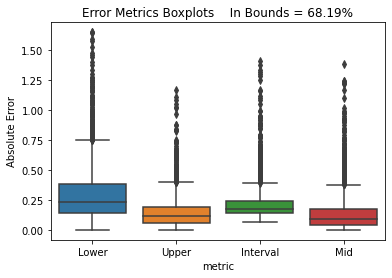

In [40]:
metric_fig = model.calculate_and_show_errors()